In [ ]:
import tensorflow as tf
from tensorflow.keras import *
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [ ]:
%env CUDA_VISIBLE_DEVICES="3"

In [ ]:
class DeconvBlock(layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__()
        if kwargs.get('use_bias') == True:
            kwargs['use_bias'] = False
        elif kwargs.get('use_bias') is None:
            kwargs.update({'use_bias': False})
            
        self.deconv = layers.Conv2DTranspose(*args, **kwargs)
        self.batch_norm = layers.BatchNormalization()
        self.leaky_relu = layers.LeakyReLU(0.2)
    
    def call(self, x):
        x = self.deconv(x)
        x = self.batch_norm(x)
        return self.leaky_relu(x)

In [ ]:
def get_decoder(embedding_dims=1024):
    return Sequential([
        layers.Reshape([1, 1, embedding_dims]),
        DeconvBlock(512, 5, activation='relu'),
        layers.UpSampling2D(),
        DeconvBlock(9*32, 5, 2, activation='relu'),
        layers.Lambda(lambda x: tf.nn.depth_to_space(x, 3)),
        layers.UpSampling2D(),
        DeconvBlock(32, 5, activation='relu'),
        layers.UpSampling2D(),
        DeconvBlock(32, 6, activation='relu'),
        DeconvBlock(32, 6, activation='relu'),
        DeconvBlock(1, 6, activation='sigmoid')
    ])

In [ ]:
def get_lstm(embedding_dims=1024, max_length=4):
    '''
    input: sequence of embedding vectors
    '''
    inp = layers.Input(shape=[None, embedding_dims])
    x = layers.Bidirectional(layers.LSTM(512, dropout=0.2, return_sequences=True))(inp)
    x = layers.Bidirectional(layers.LSTM(512, dropout=0.2, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(512))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.LeakyReLU(0.2))(x)
    out = layers.TimeDistributed(layers.Dense(embedding_dims))(x)
    
    return Model(inp, out)

In [ ]:
class Network(Model):
    def __init__(self, embedding_dims=1024):
        super().__init__()
        self.inception = applications.InceptionV3(include_top=False, input_shape=(299, 299, 3))
        self.inception.trainable = False
        self.embedder = layers.TimeDistributed(
            Sequential([
                self.inception,
                layers.Flatten(),
                layers.Dense(embedding_dims)
            ])
        )
        self.lstm = get_lstm(embedding_dims)
        self.decoder = layers.TimeDistributed(get_decoder(embedding_dims))
    
    def call(self, x):
        x = self.embedder(x)
        x = self.lstm(x)
        x = self.decoder(x)
        return x

In [ ]:
net = Network()
net.compile(loss='mse', optimizer=optimizers.Adam(1e-3))
net.build(input_shape=[None, None, 299, 299, 3])
net.summary()

In [ ]:
def draw_polygon_mask(pts, res):
    img = np.zeros((res[0], res[1]), dtype=np.uint8)
    pts = np.array(pts, np.int32).reshape((-1, 1, 2))
    cv2.fillPoly(img, [pts], (255, 255, 255))
    _, mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return mask

In [ ]:
def load_image(directory, size=(299, 299)):
    img = utils.load_img(directory, target_size=size)
    img = utils.img_to_array(img) / 255.
    return img

In [ ]:
ones = []
twos = []
threes = []
path = 'JunctionxData/images/scene3cam_03/1/'
for fname in os.listdir(path):
    ones.append(load_image(path + fname))
    
path = 'JunctionxData/images/scene3cam_03/2/'
for fname in os.listdir(path):
    twos.append(load_image(path + fname))

path = 'JunctionxData/images/scene3cam_03/3/'
for fname in os.listdir(path):
    threes.append(load_image(path + fname))
img_seq = list(zip(ones, twos, threes))
img_seqs = [np.stack(img) for img in img_seq]

input_ds = tf.data.Dataset.from_tensor_slices(img_seqs)

In [ ]:
ones, twos, threes = [], [], []

path = 'JunctionxData/groundtruth/1/'
for fname in os.listdir(path):
    if not fname.endswith('json'): continue
    with open(path + fname) as file:
        data = json.load(file)
    pts = data['coordList']
    t = tf.image.resize(draw_polygon_mask(pts, [1080, 1920])[..., None], (299, 299))
    ones.append(t)
    
path = 'JunctionxData/groundtruth/2/'
for fname in os.listdir(path):
    if not fname.endswith('json'): continue
    with open(path + fname) as file:
        data = json.load(file)
    pts = data['coordList']
    t = tf.image.resize(draw_polygon_mask(pts, [1080, 1920])[..., None], (299, 299))
    twos.append(t)
    
path = 'JunctionxData/groundtruth/3/'
for fname in os.listdir(path):
    if not fname.endswith('json'): continue
    with open(path + fname) as file:
        data = json.load(file)
    pts = data['coordList']
    t = tf.image.resize(draw_polygon_mask(pts, [1080, 1920])[..., None], (299, 299))
    threes.append(t)

target_seqs = list(zip(ones, twos, threes))
target_seqs = [np.stack(a) for a in target_seqs]
output_ds = tf.data.Dataset.from_tensor_slices(target_seqs)

In [ ]:
dataset = tf.data.Dataset.zip((input_ds, output_ds)).shuffle(input_ds.cardinality()).batch(15)

In [ ]:
history = net.fit(dataset, epochs=100)

In [ ]:
def show_tensor_images(*imgs, mode='0to1', grid='auto', figsize_each='auto', space=0.05):
    '''
    modes: '-1to1': pixel values from -1 to 1
            '0to1': pixel values from 0 to 1
            '0to255': pixel values from 0 to 255
            (mean, stddev): unnormalize
    grid: (rows, columns)
    '''

    assert all([len(img.shape) == 4 for img in imgs]) or all(
        [len(img.shape) == 3 for img in imgs])
    if len(imgs[0].shape) == 4:
        imgs = [img[i] for img in imgs for i in range(len(img))]

    num_images = len(imgs)

    if mode == '-1to1':
        imgs = [img/2 + 0.5 for img in imgs]
    elif mode == '0to1':
        pass
    elif mode == '0to255':
        imgs = [img/255.0 for img in imgs]
    elif isinstance(mode, tuple) or isinstance(mode, list):
        mean, stddev = mode
        imgs = [(img*stddev + mean)/255.0 for img in imgs]
    else:
        raise ValueError('Invalid mode')

    if grid == 'auto':
        rows = columns = int(num_images**0.5)
        residual = num_images - rows*columns
        while residual != 0:
            columns += 1
            residual = max(0, residual-rows)
            rows += 1
    else:
        assert isinstance(grid, tuple) or isinstance(grid, list)
        rows, columns = grid

    if isinstance(figsize_each, int) or isinstance(figsize_each, float):
        figsize_each = (figsize_each,)*2

    if figsize_each == 'auto':
        width = 4 * columns
        height = 4 * rows
    else:
        width = figsize_each[0] * columns
        height = figsize_each[1] * rows

    fig = plt.figure(num_images, figsize=[width, height])
    plt.subplots_adjust(wspace=space, hspace=space)
    for i in range(num_images):
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
        
    plt.show()


In [32]:
class ExportModel(tf.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    @tf.function(input_signature=[
        tf.TensorSpec([None, None, 299, 299, 3])
    ])
    def __call__(self, x):
        return self.model(x)
        

In [33]:
tf.saved_model.save(ExportModel(net), 'funxmodel')

INFO:tensorflow:Assets written to: funxmodel/assets


INFO:tensorflow:Assets written to: funxmodel/assets


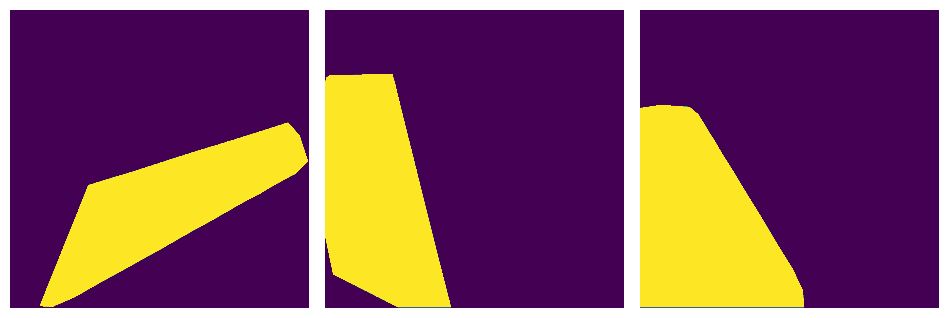

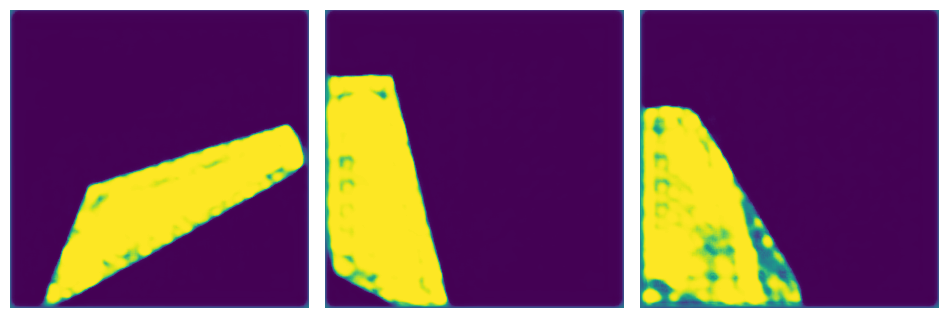

In [37]:
show_tensor_images(y[0])
show_tensor_images(net(x)[0])

In [ ]:
net.save_weights('net_weights.h5')

In [38]:
out = net(x)[0]

In [63]:
def frame_iterator(file_name, fps):
    cap = cv2.VideoCapture(file_name)
    wait_time = int(1000 / fps)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame
        cv2.waitKey(wait_time)
    cap.release()

In [64]:
a = frame_iterator('CAM_2.mp4', 5)

In [105]:
def find_polygon_coordinates(image_array, threshold=128, contour_approximation=0.02):
    # Ensure the input image is grayscale
    if image_array.ndim == 3:
        image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    else:
        image = image_array

    # Convert the grayscale image to binary using a threshold
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumes the object is the largest contour in the image)
    max_contour = max(contours, key=cv2.contourArea)

    # Simplify the contour into a polygon
    epsilon = contour_approximation * cv2.arcLength(max_contour, True)
    polygon = cv2.approxPolyDP(max_contour, epsilon, True)

    # Convert polygon coordinates to a list of tuples
    polygon_coordinates = [tuple(coord[0]) for coord in polygon]

    return polygon_coordinates

In [122]:
def coord(gray):
    dst = cv2.cornerHarris(gray,5,3,0.04)
    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    return corners

In [176]:
def two_cam(father_path):
    path1, path2 = os.listdir(father_path)
    cam1 = frame_iterator(path1, 5)
    cam2 = frame_iterator(path2, 5)
    try:
        a = next(cam1)
        b = next(cam2)
        a, b = tf.image.resize((a, b), (299, 299))
        x = tf.stack((a, b))[None, ...]
        pred = net(x)[0]

    except StopIteration:
        pass
    pred = (pred * 255.).numpy()
    return {'cam1': coord(pred[0]), 'cam2': coord(pred[1])}

def three_cam(father_path):
    path1, path2, path3 = os.listdir(father_path)
    cam1 = frame_iterator(path1, 5)
    cam2 = frame_iterator(path2, 5)
    cam3 = frame_iterator(path3, 5)
    try:
        a = next(cam1)
        b = next(cam2)
        c = next(cam3)
        a, b, c = tf.image.resize((a, b, c), (299, 299))
        x = tf.stack((a, b, c))[None, ...]
        pred = net(x)[0]

    except StopIteration:
        pass
    pred = (pred * 255.).numpy()
    return {'cam1': coord(pred[0]),
            'cam2': coord(pred[1]),
            'cam3': coord(pred[2])}

def four_cam(father_path):
    path1, path2, path3, path4 = os.listdir(father_path)
    cam1 = frame_iterator(path1, 5)
    cam2 = frame_iterator(path2, 5)
    cam3 = frame_iterator(path3, 5)
    cam4 = frame_iterator(path4, 5)
    try:
        a = next(cam1)
        b = next(cam2)
        c = next(cam3)
        d = next(cam4)
        a, b, c, d = tf.image.resize((a, b, c, d), (299, 299))
        x = tf.stack((a, b, c, d))[None, ...]
        pred = net(x)[0]

    except StopIteration:
        pass
    pred = (pred * 255.).numpy()
    return {'cam1': coord(pred[0]),
            'cam2': coord(pred[1]),
            'cam3': coord(pred[2]),
            'cam4': coord(pred[3])}

In [177]:
res = two_cam('scene2cam_02/scene2cam_02/')
res['cam1'] = res['cam1'].astype(int)
res['cam2'] = res['cam2'].astype(int)

In [168]:
# scene2cam_01
cam1txt = ''
cam2txt = ''
for i in range(1, 21):
#    x, y = res['cam1'][i]
    cam1txt += f"frame_{i}, ("
    for x, y in res['cam1']:
        cam1txt += f'{x},{y},'
    cam1txt += '), 1.1\n'
    
for i in range(1, 21):
#    x, y = res['cam1'][i]
    cam2txt += f"frame_{i}, ("
    for x, y in res['cam2']:
        cam2txt += f'{x},{y},'
    cam2txt += '), 1.0\n'

In [174]:
print(cam1txt)

frame_1, (153,148,65,67,18,68,26,70,51,78,7,81,20,80,48,87,61,87,63,89,68,88,56,91,19,90,7,95,8,105,14,107,14,107,7,111,72,112,54,119,70,117,76,130,85,137,72,143,255,142,247,143,281,141,281,141,278,148,72,153,84,155,262,156,97,188,98,207,69,206,98,207,61,217,58,230,52,241,50,246,113,253,45,258,45,258,49,264,39,280,80,276,69,283,), 1.1
frame_2, (153,148,65,67,18,68,26,70,51,78,7,81,20,80,48,87,61,87,63,89,68,88,56,91,19,90,7,95,8,105,14,107,14,107,7,111,72,112,54,119,70,117,76,130,85,137,72,143,255,142,247,143,281,141,281,141,278,148,72,153,84,155,262,156,97,188,98,207,69,206,98,207,61,217,58,230,52,241,50,246,113,253,45,258,45,258,49,264,39,280,80,276,69,283,), 1.1
frame_3, (153,148,65,67,18,68,26,70,51,78,7,81,20,80,48,87,61,87,63,89,68,88,56,91,19,90,7,95,8,105,14,107,14,107,7,111,72,112,54,119,70,117,76,130,85,137,72,143,255,142,247,143,281,141,281,141,278,148,72,153,84,155,262,156,97,188,98,207,69,206,98,207,61,217,58,230,52,241,50,246,113,253,45,258,45,258,49,264,39,280,80,276,69,

In [170]:
print(cam2txt)

frame_1, (149,148,38,96,7,98,14,98,42,99,69,110,69,113,72,115,63,117,10,120,26,119,69,121,100,187,95,238,94,259,10,265,80,267,21,269,44,270,90,270,42,280,13,284,13,284,58,285,105,290,121,289,101,295,), 1.0
frame_2, (149,148,38,96,7,98,14,98,42,99,69,110,69,113,72,115,63,117,10,120,26,119,69,121,100,187,95,238,94,259,10,265,80,267,21,269,44,270,90,270,42,280,13,284,13,284,58,285,105,290,121,289,101,295,), 1.0
frame_3, (149,148,38,96,7,98,14,98,42,99,69,110,69,113,72,115,63,117,10,120,26,119,69,121,100,187,95,238,94,259,10,265,80,267,21,269,44,270,90,270,42,280,13,284,13,284,58,285,105,290,121,289,101,295,), 1.0
frame_4, (149,148,38,96,7,98,14,98,42,99,69,110,69,113,72,115,63,117,10,120,26,119,69,121,100,187,95,238,94,259,10,265,80,267,21,269,44,270,90,270,42,280,13,284,13,284,58,285,105,290,121,289,101,295,), 1.0
frame_5, (149,148,38,96,7,98,14,98,42,99,69,110,69,113,72,115,63,117,10,120,26,119,69,121,100,187,95,238,94,259,10,265,80,267,21,269,44,270,90,270,42,280,13,284,13,284,58,285,1